In [445]:
import numpy as np
from sklearn import (
    ensemble,
    model_selection,
    preprocessing,
    tree
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    cohen_kappa_score,
    confusion_matrix,
    plot_confusion_matrix,
    classification_report
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Gather Pred Data

In [446]:
def getstats(stat, stat_name, getrounds):

    # in the requests header seems to be a constant token ('x-api-key') that is needed
    X_API_KEY = "da2-gsrx5bibzbb4njvhl7t37wqyl4"

    YEAR = 2023  # Stats Season change this
    STAT_ID = stat  # Stat ID

    # prepare the payload
    payload = {
        "operationName": "StatDetails",
        "variables": {
            "tourCode": "R",
            "statId": STAT_ID,
            "year": YEAR,
            "eventQuery": None
        },
        "query": "query StatDetails($tourCode: TourCode!, $statId: String!, $year: Int, $eventQuery: StatDetailEventQuery) {\n  statDetails(\n    tourCode: $tourCode\n    statId: $statId\n    year: $year\n    eventQuery: $eventQuery\n  ) {\n    tourCode\n    year\n    displaySeason\n    statId\n    statType\n    tournamentPills {\n      tournamentId\n      displayName\n    }\n    yearPills {\n      year\n      displaySeason\n    }\n    statTitle\n    statDescription\n    tourAvg\n    lastProcessed\n    statHeaders\n    statCategories {\n      category\n      displayName\n      subCategories {\n        displayName\n        stats {\n          statId\n          statTitle\n        }\n      }\n    }\n    rows {\n      ... on StatDetailsPlayer {\n        __typename\n        playerId\n        playerName\n        country\n        countryFlag\n        rank\n        rankDiff\n        rankChangeTendency\n        stats {\n          statName\n          statValue\n          color\n        }\n      }\n      ... on StatDetailTourAvg {\n        __typename\n        displayName\n        value\n      }\n    }\n  }\n}"  
      }

    # post the request
    page = requests.post("https://orchestrator.pgatour.com/graphql", json=payload, headers={"x-api-key": X_API_KEY})

    # check for status code
    page.raise_for_status()

    # get the data
    data = page.json()["data"]["statDetails"]["rows"]

    data = filter(lambda item: item.get("__typename", NaN) == "StatDetailsPlayer", data)

    if getrounds == 1:
        # format to a table that is in the webpage
        table = map(lambda item: {
            "player_name": item["playerName"],
            "rounds": item["stats"][3]["statValue"],
            stat_name: item["stats"][0]["statValue"],
        }, data)
    else:
        # format to a table that is in the webpage
        table = map(lambda item: {
            "player_name": item["playerName"],
            stat_name: item["stats"][0]["statValue"],
        }, data)

    # convert the dataframe
    s = pd.DataFrame(table)
    

    return s

In [447]:
stat_list = ["120",
             "138",
             "127",
             "02675",
             "02674",
             "02564",
            "101",
            "103",
            "119",
            "160",
            "102",
            "331",
            "130",
            "02568",
            "02567",
            "02569",
            "143",
            "142",
            "144",
            "02341",
            "459",
            "460",
            "01008",
            "190",
            "199",
            "431",
            "437",
            "486",
            "111",
            "374",
            "408",
            "02328",
            "405",
            "484",
            "118"]
name_list = ["score_average",
            "wins",
            "ranking",
            "sg_total",
            "sg_t2g",
            "sg_putt",
            "driving_distance",
            "gir",
            "putts_round",
            "bounce_back",
            "driving_accuracy",
            "hole_proximity",
            "scramble",
            "sg_approach",
            "sg_tee",
            "sg_ar",
            "par4_sa",
            "par3_sa",
            "par5_sa",
            "covered_tee",
            "left_rough",
            "right_rough",
            "fair_bunk",
            "gir_fair",
            "gir_not_fair",
            "prox_fair",
            "prox_rough",
            "go_for_green",
            "sand_save",
            "prox_arg",
            "putt_25",
            "putt15_25",
            "putt10_15",
            "putt_10",
            "finround_sa"]

In [448]:
stat_dict = {stat_list[i]: name_list[i] for i in range(len(stat_list))}

In [449]:
stat_dict["120"]

'score_average'

In [450]:
df2023 = getstats("120", "score_average", 1)
df2023.head()

,player_name,rounds,score_average
0,Jon Rahm,29,68.903
1,Scottie Scheffler,36,69.105
2,Jason Day,44,69.488
3,Max Homa,36,69.512
4,Tyrrell Hatton,24,69.554


In [451]:
for i in range(2, len(stat_dict)):
    df_i = getstats(stat_list[i], stat_dict[stat_list[i]], 0)
    
    df2023 = df2023.merge(df_i, on='player_name', how='left')

In [452]:
df2023["year"] = 2023
df2023.head()

,player_name,rounds,score_average,ranking,sg_total,sg_t2g,sg_putt,driving_distance,gir,putts_round,...,prox_rough,go_for_green,sand_save,prox_arg,putt_25,putt15_25,putt10_15,putt_10,finround_sa,year
0,Jon Rahm,29,68.903,193,2.498,1.807,.691,314.1,72.80,28.07,...,"43' 4""",30.59,54.29,"7' 4""",7.34,24.47,35.62,88.40,69.00,2023
1,Scottie Scheffler,36,69.105,334,2.283,2.268,.016,308.7,73.77,28.47,...,"44' 8""",27.18,36.00,"7' 1""",7.20,13.21,32.05,87.16,67.89,2023
2,Jason Day,44,69.488,356,1.903,1.290,.613,302.6,69.82,28.23,...,"43' 9""",19.61,58.62,"7' 0""",2.44,23.44,30.14,89.47,67.40,2023
3,Max Homa,36,69.512,286,2.166,1.447,.719,301.7,68.67,27.78,...,"47' 3""",24.30,51.22,"7' 4""",8.09,18.94,38.64,89.29,68.56,2023
4,Tyrrell Hatton,24,69.554,395,2.005,1.453,.552,304.7,65.74,28.25,...,"43' 1""",29.03,44.74,"7' 4""",7.41,18.46,26.67,88.89,69.00,2023


# Train Model

### Load and Process Training Data

In [453]:
#Load Pre 2023 Data
data = pd.read_csv('/Users/samgreene/2022Masters_pred_data.csv')

In [454]:
data22 = pd.read_csv('/Users/samgreene/2022Masters_PREDICTIONDATA.csv')
mdata22 = pd.read_csv('/Users/samgreene/2022MastersFinish.csv')

#Data Cleaning - Drop unnamed column
mdata22 = mdata22.drop(mdata22.columns[0], axis = 1)

data22 = data22.merge(mdata22, on='player_name', how='left')

data = data.append(data22)
data = data.append(df2023)

In [455]:
#Data Cleaning - Drop unnamed column
data = data.drop(data.columns[0], axis = 1)

In [456]:
data = data[data['prox_arg'].notna()]

In [457]:
#Check for non-nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 205
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              1446 non-null   int64  
 1   player_name       1446 non-null   object 
 2   ranking           1446 non-null   object 
 3   top_10            1169 non-null   float64
 4   wins              1048 non-null   float64
 5   score_average     1418 non-null   object 
 6   rounds            1418 non-null   object 
 7   bounce_back       1446 non-null   object 
 8   driving_accuracy  1446 non-null   object 
 9   driving_distance  1446 non-null   object 
 10  gir               1446 non-null   object 
 11  hole_proximity    1446 non-null   object 
 12  x_of_attempts     1240 non-null   object 
 13  putts_round       1446 non-null   object 
 14  scramble          1446 non-null   object 
 15  sg_putt           1446 non-null   object 
 16  sg_t2g            1446 non-null   object 
 

In [458]:
##Clean up some of the variables
def rem_t(string):
    if type(string) == str:
        if string[0] == 'T':
            string = int(string[1:])
        else:
            string = string
    return string

def top_10(pos):
    if type(pos) == int:
        if pos <= 10 and pos > 0:
            top_10 = 1
        else:
            top_10 = 0
    else:
        if pos == 'Win' or pos == '1':
            top_10 = 1
        else:
            top_10 = 0
    return top_10

def str_int(x):
    if type(x) == str:  
        x = x.replace(",","")
        x = float(x)
    return x

def winner(x):
    if x == 'Win' or x == '1' or x == 1:
        win = 1
    else:
        win = 0
    return win

def parse_ht(ht):
    if ht == 'NaN':
        return float('NaN')
    else:
    # format: 7' 0.0"
        ht = str(ht)
        ht_ = ht.split("' ")
        ft_ = float(ht_[0])
        in_ = float(ht_[1].replace("\"",""))
        return (12*ft_) + in_

In [459]:
#Clean masters_finish
data['masters_finish'] = data['masters_finish'].replace('CUT', '0')
data['masters_finish'] = data['masters_finish'].replace('Win', '1')
data['masters_finish'] = data['masters_finish'].replace('WD', '0')
data['masters_finish'] = data['masters_finish'].replace('DQ', '0')
data['masters_finish'] = data['masters_finish'].replace(NaN, '0')
data['masters_finish'] = data['masters_finish'].apply(rem_t)
data['masters_finish'] = pd.to_numeric(data['masters_finish'])

In [460]:

#Change these two to correct data type
data['x_of_attempts'] = data['x_of_attempts'].apply(str_int)

#Get binary target variable
data['masters_win'] = data['masters_finish'].apply(winner)

#Drop total proximity and number of attempts
data = data.drop('hole_proximity', axis = 1)
data = data.drop('x_of_attempts', axis = 1)

#Create top 10 variable
data['masters_t10'] = data['masters_finish'].apply(top_10)

#Change from ft'inch" to inches
data['prox_arg'] = data['prox_arg'].apply(parse_ht)
data['prox_fair'] = data['prox_fair'].apply(parse_ht)
data['prox_rough'] = data['prox_rough'].apply(parse_ht)

#Impute missing values with median

##data.at[873, 'score_average'] = data.loc[data['masters_win'] == 1]['score_average'].median()
##data.at[873, 'rounds'] = data.loc[data['masters_win'] == 1]['score_average'].median()

data['score_average'] = data['score_average'].fillna(
    data['score_average'].median())

data['rounds'] = data['rounds'].fillna(
    data['rounds'].median())

data['gir_fair'] = data['gir_fair'].fillna(
    data['gir_fair'].median())

data['putt_25'] = data['putt_25'].fillna(
    data['putt_25'].median())

data['putt15_25'] = data['putt15_25'].fillna(
    data['putt15_25'].median())

data['putt10_15'] = data['putt10_15'].fillna(
    data['putt10_15'].median())

data['finround_sa'] = data['finround_sa'].fillna(
    data['finround_sa'].median())

data['top_10'] = data['top_10'].fillna(
    data['top_10'].median())

In [461]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 205
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              1446 non-null   int64  
 1   player_name       1446 non-null   object 
 2   ranking           1446 non-null   object 
 3   top_10            1446 non-null   float64
 4   wins              1048 non-null   float64
 5   score_average     1446 non-null   object 
 6   rounds            1446 non-null   object 
 7   bounce_back       1446 non-null   object 
 8   driving_accuracy  1446 non-null   object 
 9   driving_distance  1446 non-null   object 
 10  gir               1446 non-null   object 
 11  putts_round       1446 non-null   object 
 12  scramble          1446 non-null   object 
 13  sg_putt           1446 non-null   object 
 14  sg_t2g            1446 non-null   object 
 15  sg_total          1446 non-null   object 
 16  sg_approach       1446 non-null   object 
 

In [462]:
#Look at past winners data
winners = data.loc[data['masters_win'] == 1].sort_values(by='year')

winners

,year,player_name,ranking,top_10,wins,score_average,rounds,bounce_back,driving_accuracy,driving_distance,...,prox_arg,putt_25,putt15_25,putt10_15,putt_10,finround_sa,masters_finish,total_score,masters_win,masters_t10
1098,2004,Phil Mickelson,4,7.0,1.0,69.111,33.0,37.93,62.53,294.5,...,83.0,2.25,17.39,39.24,87.05,70.29,1,279.0,1,1
1424,2005,Tiger Woods,5,3.0,2.0,69.667,24.0,28.57,57.37,302.7,...,79.0,5.06,18.75,26.98,86.58,69.83,1,276.0,1,1
1100,2006,Phil Mickelson,3,5.0,1.0,69.148,32.0,20.63,60.64,298.8,...,79.0,3.85,15.73,28.17,89.26,71.29,1,281.0,1,1
1569,2007,Zach Johnson,37,1.0,0.0,70.174,22.0,12.28,71.72,276.3,...,93.0,13.7,13.51,36.07,88.32,71.4,1,289.0,1,1
1491,2008,Trevor Immelman,143,0.0,0.0,71.282,22.0,13.56,61.96,290.1,...,80.0,4.3,13.51,17.54,85.49,71.67,1,280.0,1,1
61,2009,Ángel Cabrera,141,0.0,0.0,70.684,15.0,13.95,46.94,308.3,...,72.0,2.99,13.16,32.5,86.69,67.0,1,276.0,1,1
1104,2010,Phil Mickelson,25,1.0,0.0,70.377,28.0,22.54,47.83,299.4,...,79.0,2.13,13.51,18.84,88.0,71.43,1,272.0,1,1
259,2011,Charl Schwartzel,76,0.0,0.0,70.387,18.0,25.58,59.82,291.4,...,82.0,10.59,18.75,32.43,87.67,69.5,1,274.0,1,1
214,2012,Bubba Watson,8,3.0,0.0,69.997,26.0,19.3,56.76,316.9,...,92.0,10.31,14.44,21.88,84.97,71.17,1,278.0,1,1
216,2014,Bubba Watson,12,5.0,1.0,69.803,28.0,20.41,56.57,317.7,...,103.0,5.08,24.53,27.08,86.05,68.83,1,280.0,1,1


In [463]:
#Look at past top 10 data
top10s = data.loc[data['masters_t10'] == 1].sort_values(by='year')

top10s

,year,player_name,ranking,top_10,wins,score_average,rounds,bounce_back,driving_accuracy,driving_distance,...,prox_arg,putt_25,putt15_25,putt10_15,putt_10,finround_sa,masters_finish,total_score,masters_win,masters_t10
1098,2004,Phil Mickelson,4,7.0,1.0,69.111,33.0,37.93,62.53,294.5,...,83.0,2.25,17.39,39.24,87.05,70.29,1,279.0,1,1
761,2004,K.J. Choi,72,2.0,0.0,70.719,25.0,16.95,63.88,282.4,...,96.0,2.3,11.11,33.87,85.86,71.2,3,282.0,0,1
820,2004,Kirk Triplett,20,3.0,0.0,70.488,25.0,28.89,75.21,271.9,...,78.0,5.19,15.71,41.07,84.27,71.6,6,286.0,0,1
112,2004,Bernhard Langer,41,2.0,0.0,71.062,33.0,22.78,62.61,282.7,...,91.0,7.75,18.6,25.26,87.17,72.38,4,285.0,0,1
1519,2004,Vijay Singh,5,4.0,1.0,69.268,32.0,37.5,62.17,293.9,...,86.0,3.42,20.0,30.43,85.49,70.0,6,286.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,2022,Sungjae Im,10,4.0,1.0,70.187,47.0,31.17,63.47,302.3,...,78.0,5.56,16.3,36.19,89.26,68.7,9,NaN,0,1
4,2022,Collin Morikawa,5,5.0,NaN,70.026,26.0,19.15,66.78,302.4,...,94.0,2.9,21.67,37.29,88.05,66.2,5,NaN,0,1
0,2022,Justin Thomas,1,5.0,NaN,69.617,35.0,21.82,57.14,311.1,...,78.0,9.41,12.9,28.4,87.55,68.75,8,NaN,0,1
11,2022,Scottie Scheffler,12,6.0,3.0,69.87,49.0,27.08,57.19,308.9,...,79.0,6.38,20.69,37.36,88.2,69.0,1,NaN,1,1


### Dist Check

In [464]:
train_data = data.loc[data["year"] < 2023]
pred_data = data.loc[data["year"] == 2023]

In [465]:
#Get predictor data
columns = list(train_data.columns.values)
predictors = columns[3:]
predictors.remove('masters_finish')
predictors.remove('masters_t10')
predictors.remove('masters_win')
predictors.remove('total_score')
predictors_data = train_data[predictors]

len(predictors)

35

/Users/samgreene/opt/anaconda3/lib/python3.8/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/samgreene/opt/anaconda3/lib/python3.8/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


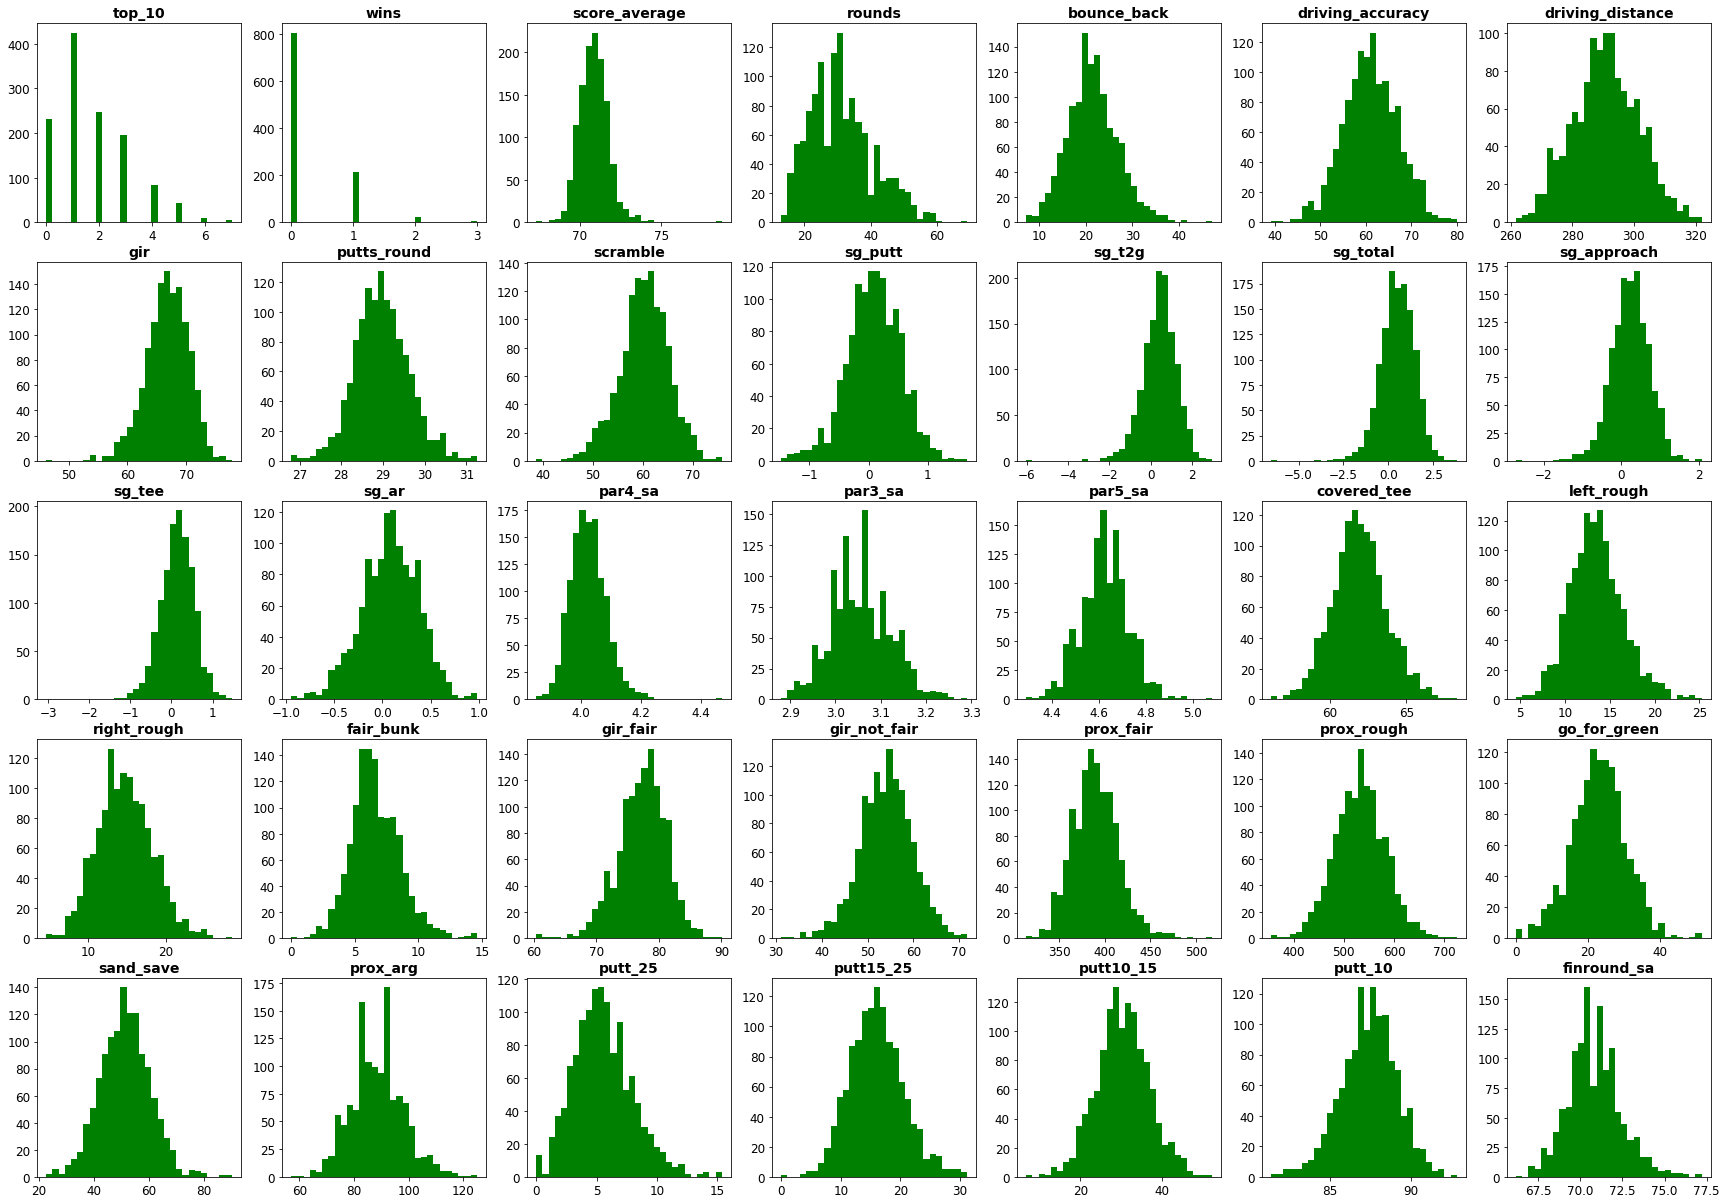

In [466]:
#Plot distributions of every possible predictor
plt.figure(figsize=(30,30))

for i in range(0, len(predictors)):
    plt.subplot(7,7,i+1)
    plt.gca().set_title(predictors[i], fontsize=14, fontweight='bold')
    plt.hist(predictors_data.iloc[:,i], color = 'green', bins = 30)

### Set Predictors

In [467]:
predictors = ['score_average',
 'bounce_back',
 'driving_distance',
 'gir',
 'putts_round',
 'scramble',
 'sg_putt',
 'sg_t2g',
 'sg_approach',
 'sg_tee',
 'sg_ar',
 'par3_sa',
 'par5_sa',
 'left_rough',
 'right_rough',
 'fair_bunk',
 'gir_fair',
 'gir_not_fair',
 'prox_fair',
 'prox_rough',
 'go_for_green',
 'sand_save',
 'prox_arg',
 'putt_25',
 'putt15_25',
 'putt10_15',
 'putt_10',
 'finround_sa',
 'rounds']

## Quick Test

In [468]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
        y_test = clf.predict(X_val)
        #print(y_test.value_counts())
        plot_confusion_matrix(clf,  X_val, clf.predict(X_val))
        print("End of validation Result\n")

In [469]:
#Split into predictors and target
X = train_data[predictors]
y = train_data['masters_t10']

#Split into train and val
X_train, X_val, y_train, y_val = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=69)

print(len(X_train))
print(len(X_val))
print(len(y_train))
print(len(y_val))

992
248
992
248


In [470]:
#Standardize Data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_scaled = sc.fit_transform(X)

In [471]:
#Upsample minority class
smote = SMOTE(random_state = 42, sampling_strategy = 0.5)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [472]:
y_train_sm.value_counts()

0    856
1    428
Name: masters_t10, dtype: int64

## Log Reg

In [473]:
clf_log_reg = LogisticRegression(C = 0.001, penalty = 'l2', solver = 'liblinear')
clf_log_reg.fit(X_train_sm, y_train_sm)

LogisticRegression(C=0.001, solver='liblinear')

Validation Result:

accuracy score: 0.6774



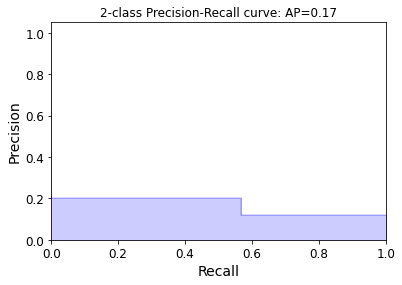

roc auc score: 0.6296636085626911



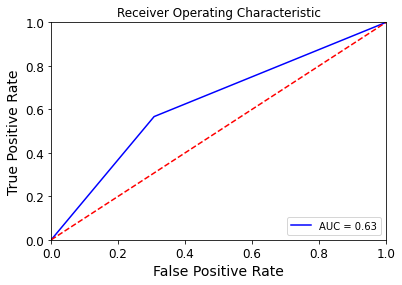

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.69      0.79       218
           1       0.20      0.57      0.30        30

    accuracy                           0.68       248
   macro avg       0.56      0.63      0.54       248
weighted avg       0.83      0.68      0.73       248


Confusion Matrix: 
 [[151  67]
 [ 13  17]]

End of validation Result



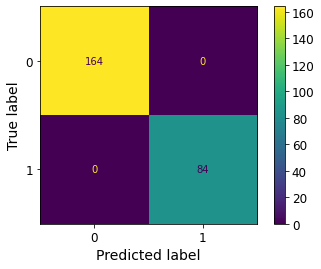

In [474]:
clf_score(clf_log_reg, X_train_sm, y_train_sm, X_val, y_val, train=False)

## SVC

In [475]:
from sklearn.svm import SVC

In [476]:
svc = SVC(random_state = 42, kernel = 'rbf')
model = svc.fit(X_train_sm, y_train_sm)

Validation Result:

accuracy score: 0.8266



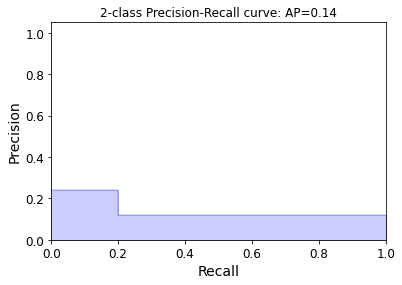

roc auc score: 0.5564220183486238



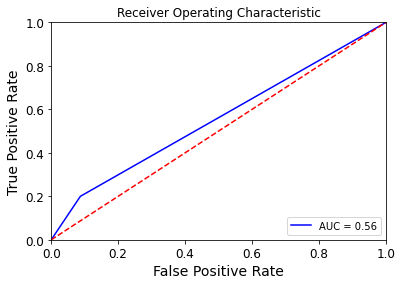

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       218
           1       0.24      0.20      0.22        30

    accuracy                           0.83       248
   macro avg       0.57      0.56      0.56       248
weighted avg       0.81      0.83      0.82       248


Confusion Matrix: 
 [[199  19]
 [ 24   6]]

End of validation Result



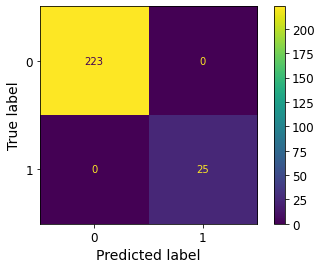

In [477]:
clf_score(model, X_train_sm, y_train_sm, X_val, y_val, train=False)

# Made Predictions

In [478]:
participants = pd.read_csv('/Users/samgreene/Downloads/export_masters_4_2_2023.csv')

In [479]:
participants = participants["Golfer"]
participants

0               Scottie Scheffler
1                    Rory McIlroy
2                        Jon Rahm
3                 Patrick Cantlay
4                   Cameron Smith
                 ...             
83                     Larry Mize
84    Mateo Fernandez de Oliveira
85                      Mike Weir
86                     Sandy Lyle
87                    Vijay Singh
Name: Golfer, Length: 88, dtype: object

In [480]:
masters_pred = pred_data[pred_data['player_name'].isin(participants)]

In [481]:
masters_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 201
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              49 non-null     int64  
 1   player_name       49 non-null     object 
 2   ranking           49 non-null     object 
 3   top_10            49 non-null     float64
 4   wins              0 non-null      float64
 5   score_average     49 non-null     object 
 6   rounds            49 non-null     object 
 7   bounce_back       49 non-null     object 
 8   driving_accuracy  49 non-null     object 
 9   driving_distance  49 non-null     object 
 10  gir               49 non-null     object 
 11  putts_round       49 non-null     object 
 12  scramble          49 non-null     object 
 13  sg_putt           49 non-null     object 
 14  sg_t2g            49 non-null     object 
 15  sg_total          49 non-null     object 
 16  sg_approach       49 non-null     object 
 17

### Log Reg Prediction

In [482]:
X_train = train_data[predictors]
y_train = train_data['masters_t10']

#Standardize Predictors and Test
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
    
smote = SMOTE(random_state = 42, sampling_strategy = 0.2)
    
X_train_sm, y_train_sm = smote.fit_resample(X_train_std, y_train)

#Train Model
lr = LogisticRegression(C = 0.001, penalty = 'l2', solver = 'liblinear', random_state = 42)
model = lr.fit(X_train_sm, y_train_sm)

In [483]:
X_pred = masters_pred[predictors]
X_pred_std  = std_scale.transform(X_pred)

y_pred = model.predict(X_pred_std)
pred_proba = model.predict_proba(X_pred_std)

masters_pred['prediction_lr'] = y_pred.tolist()
    
probs = []
for i in range(0, len(pred_proba)):
        prob = pred_proba[i,1]
        probs.append(prob)
        
masters_pred['prob_pred_lr'] = probs

<ipython-input-483-54ccd8cd07f3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masters_pred['prediction_lr'] = y_pred.tolist()
<ipython-input-483-54ccd8cd07f3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masters_pred['prob_pred_lr'] = probs


In [484]:
masters_pred[masters_pred['prediction_lr'] == 1]

,year,player_name,ranking,top_10,wins,score_average,rounds,bounce_back,driving_accuracy,driving_distance,...,putt15_25,putt10_15,putt_10,finround_sa,masters_finish,total_score,masters_win,masters_t10,prediction_lr,prob_pred_lr
0,2023,Jon Rahm,193,1.0,NaN,68.903,29,27.12,57.56,314.1,...,24.47,35.62,88.40,69.00,0,NaN,0,0,1,0.589308
1,2023,Scottie Scheffler,334,1.0,NaN,69.105,36,36.54,63.29,308.7,...,13.21,32.05,87.16,67.89,0,NaN,0,0,1,0.573357
3,2023,Max Homa,286,1.0,NaN,69.512,36,27.14,62.20,301.7,...,18.94,38.64,89.29,68.56,0,NaN,0,0,1,0.523534
4,2023,Tyrrell Hatton,395,1.0,NaN,69.554,24,30.91,64.16,304.7,...,18.46,26.67,88.89,69.00,0,NaN,0,0,1,0.512341
6,2023,Tony Finau,339,1.0,NaN,69.675,34,28.57,59.24,301.6,...,19.05,37.78,87.86,69.50,0,NaN,0,0,1,0.532354
7,2023,Rory McIlroy,694,1.0,NaN,69.701,18,24.39,51.98,326.6,...,9.23,25.00,89.55,69.50,0,NaN,0,0,1,0.543419
8,2023,Patrick Cantlay,296,1.0,NaN,69.894,26,35.29,63.86,308.2,...,13.10,28.81,90.11,68.17,0,NaN,0,0,1,0.534754


### SVC Predictions

In [485]:
X_train = train_data[predictors]
y_train = train_data['masters_t10']

#Standardize Predictors and Test
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)

#SMOTE and Random Undersampling
over = SMOTE(sampling_strategy=0.4, random_state = 69)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 69)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
    
X_train_sm, y_train_sm = pipeline.fit_resample(X_train_std, y_train)

#Run Model
svc = SVC(kernel = 'rbf', random_state = 42, gamma = 0.001, C = 10, probability = True)
model = svc.fit(X_train_sm, y_train_sm)

In [486]:
X_test = masters_pred[predictors]

X_test_std  = std_scale.transform(X_test)

y_test_pred = model.predict(X_test_std)
    
pred_proba = model.predict_proba(X_test_std)
    
masters_pred['prediction_SVC'] = y_test_pred.tolist()
    
probs = []
for i in range(0, len(pred_proba)):
        prob = pred_proba[i,1]
        probs.append(prob)
        
masters_pred['prob_pred_SVC'] = probs

<ipython-input-486-b3e98efed4ac>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masters_pred['prediction_SVC'] = y_test_pred.tolist()
<ipython-input-486-b3e98efed4ac>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masters_pred['prob_pred_SVC'] = probs


In [487]:
masters_pred[masters_pred['prediction_SVC'] == 1].sort_values('prob_pred_SVC')

,year,player_name,ranking,top_10,wins,score_average,rounds,bounce_back,driving_accuracy,driving_distance,...,putt_10,finround_sa,masters_finish,total_score,masters_win,masters_t10,prediction_lr,prob_pred_lr,prediction_SVC,prob_pred_SVC
3,2023,Max Homa,286,1.0,NaN,69.512,36,27.14,62.20,301.7,...,89.29,68.56,0,NaN,0,0,1,0.523534,1,0.569735
4,2023,Tyrrell Hatton,395,1.0,NaN,69.554,24,30.91,64.16,304.7,...,88.89,69.00,0,NaN,0,0,1,0.512341,1,0.578321
8,2023,Patrick Cantlay,296,1.0,NaN,69.894,26,35.29,63.86,308.2,...,90.11,68.17,0,NaN,0,0,1,0.534754,1,0.598449
6,2023,Tony Finau,339,1.0,NaN,69.675,34,28.57,59.24,301.6,...,87.86,69.50,0,NaN,0,0,1,0.532354,1,0.670145
7,2023,Rory McIlroy,694,1.0,NaN,69.701,18,24.39,51.98,326.6,...,89.55,69.50,0,NaN,0,0,1,0.543419,1,0.701516
0,2023,Jon Rahm,193,1.0,NaN,68.903,29,27.12,57.56,314.1,...,88.40,69.00,0,NaN,0,0,1,0.589308,1,0.780288
1,2023,Scottie Scheffler,334,1.0,NaN,69.105,36,36.54,63.29,308.7,...,87.16,67.89,0,NaN,0,0,1,0.573357,1,0.785978


# Output by Blended Probability

In [488]:
masters_pred['combined_prob'] = (masters_pred['prob_pred_SVC'] + masters_pred['prob_pred_lr'])/2

<ipython-input-488-62539d76236d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masters_pred['combined_prob'] = (masters_pred['prob_pred_SVC'] + masters_pred['prob_pred_lr'])/2


In [489]:
masters_pred.sort_values('combined_prob', ascending=False)

,year,player_name,ranking,top_10,wins,score_average,rounds,bounce_back,driving_accuracy,driving_distance,...,finround_sa,masters_finish,total_score,masters_win,masters_t10,prediction_lr,prob_pred_lr,prediction_SVC,prob_pred_SVC,combined_prob
0,2023,Jon Rahm,193,1.0,NaN,68.903,29,27.12,57.56,314.1,...,69.00,0,NaN,0,0,1,0.589308,1,0.780288,0.684798
1,2023,Scottie Scheffler,334,1.0,NaN,69.105,36,36.54,63.29,308.7,...,67.89,0,NaN,0,0,1,0.573357,1,0.785978,0.679668
7,2023,Rory McIlroy,694,1.0,NaN,69.701,18,24.39,51.98,326.6,...,69.50,0,NaN,0,0,1,0.543419,1,0.701516,0.622468
6,2023,Tony Finau,339,1.0,NaN,69.675,34,28.57,59.24,301.6,...,69.50,0,NaN,0,0,1,0.532354,1,0.670145,0.601249
8,2023,Patrick Cantlay,296,1.0,NaN,69.894,26,35.29,63.86,308.2,...,68.17,0,NaN,0,0,1,0.534754,1,0.598449,0.566601
3,2023,Max Homa,286,1.0,NaN,69.512,36,27.14,62.20,301.7,...,68.56,0,NaN,0,0,1,0.523534,1,0.569735,0.546635
4,2023,Tyrrell Hatton,395,1.0,NaN,69.554,24,30.91,64.16,304.7,...,69.00,0,NaN,0,0,1,0.512341,1,0.578321,0.545331
2,2023,Jason Day,356,1.0,NaN,69.488,44,21.79,62.25,302.6,...,67.40,0,NaN,0,0,0,0.494570,0,0.517965,0.506267
38,2023,Jordan Spieth,509,1.0,NaN,70.475,32,27.63,53.24,302.7,...,70.43,0,NaN,0,0,0,0.481102,0,0.500000,0.490551
9,2023,Viktor Hovland,237,1.0,NaN,69.921,36,27.38,63.62,305.4,...,69.78,0,NaN,0,0,0,0.487544,0,0.484808,0.486176
